In [1]:
from pyspark.sql import SparkSession
spark= SparkSession.builder.getOrCreate()

In [2]:
# reading in the data
infile = 'default.csv'
df = spark.read.csv(infile, inferSchema=True, header = True)

In [3]:
df.printSchema()
type(df)

root
 |-- ID: integer (nullable = true)
 |-- LIMIT_BAL: integer (nullable = true)
 |-- SEX: integer (nullable = true)
 |-- EDUCATION: integer (nullable = true)
 |-- MARRIAGE: integer (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- PAY_0: integer (nullable = true)
 |-- PAY_2: integer (nullable = true)
 |-- PAY_3: integer (nullable = true)
 |-- PAY_4: integer (nullable = true)
 |-- PAY_5: integer (nullable = true)
 |-- PAY_6: integer (nullable = true)
 |-- BILL_AMT1: integer (nullable = true)
 |-- BILL_AMT2: integer (nullable = true)
 |-- BILL_AMT3: integer (nullable = true)
 |-- BILL_AMT4: integer (nullable = true)
 |-- BILL_AMT5: integer (nullable = true)
 |-- BILL_AMT6: integer (nullable = true)
 |-- PAY_AMT1: integer (nullable = true)
 |-- PAY_AMT2: integer (nullable = true)
 |-- PAY_AMT3: integer (nullable = true)
 |-- PAY_AMT4: integer (nullable = true)
 |-- PAY_AMT5: integer (nullable = true)
 |-- PAY_AMT6: integer (nullable = true)
 |-- default payment next month: inte

pyspark.sql.dataframe.DataFrame

In [4]:
# rename response variable as "label" for easier using
df2 = df.withColumnRenamed("default payment next month", "label")
type(df2)

pyspark.sql.dataframe.DataFrame

+-----+-----+
|label|count|
+-----+-----+
|    1| 6636|
|    0|23364|
+-----+-----+



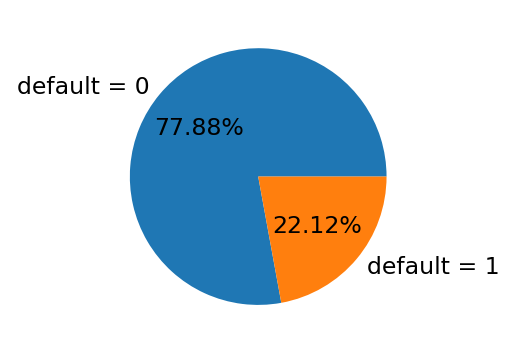

In [5]:
#check the distribution of the response variable, we found that the data is highly imbalanced

default0 = df2.filter(df2['label'] == 0).count()
default1 = df2.filter(df2['label'] == 1).count()
default_ls = [default0,default1]
default_lablel = ["default = 0", "default = 1"]
df2.groupBy('label').count().show()
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi']= 170

fig = plt.figure(figsize=(2.5,2.5))
plt.pie(default_ls, labels=default_lablel, autopct = '%.2f%%')
plt.show()

## Data Splitting

In [6]:
#Split data into train set (70%), test set (30%) using seed=314
training, test = df2.randomSplit([0.7, 0.3], seed=314)

#Count records in datasets
train_count = training.count()
test_count = test.count()
raw_count = df2.count()
records_count = spark.createDataFrame([
    ('Training set', train_count),
    ('Test set', test_count),
    ('Raw data', raw_count),
], ["Datasets", "Count"])

records_count.show()

+------------+-----+
|    Datasets|Count|
+------------+-----+
|Training set|20925|
|    Test set| 9075|
|    Raw data|30000|
+------------+-----+



In [7]:
#Balance the data using oversampling method. Do this on train set only. 

from pyspark.sql.functions import col, explode, array, lit

major_train = training.filter(col('label') == 0)
minor_train = training.filter(col('label') == 1)
ratio = int(major_train.count()/minor_train.count())
ratio_range = range(ratio)

oversampled_train = minor_train.withColumn("dummy", explode(array([lit(x) for x in ratio_range]))).drop('dummy')

final_train = major_train.unionAll(oversampled_train)

+-----+-----+
|label|count|
+-----+-----+
|    1| 4640|
|    0|16285|
+-----+-----+



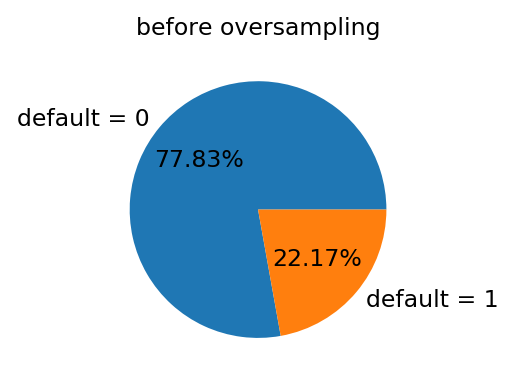

In [8]:
#check the distribution of the response variable for training set (before oversampling)
train0 = training.filter(training['label'] == 0).count()
train1 = training.filter(training['label'] == 1).count()
train_ls = [train0,train1]
train_lablel = ["default = 0", "default = 1"]
training.groupBy('label').count().show()

# plot pie chart
fig = plt.figure(figsize=(2.5,2.5))
plt.pie(train_ls, labels=train_lablel, autopct = '%.2f%%')
plt.title("before oversampling", fontsize=10)
plt.show()

+-----+-----+
|label|count|
+-----+-----+
|    1|13920|
|    0|16285|
+-----+-----+



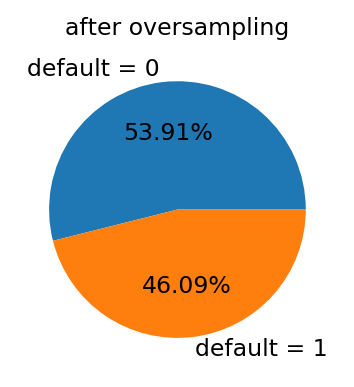

In [9]:
#check the distribution of the response variable for training set (after oversampling)
final_train0 = final_train.filter(final_train['label'] == 0).count()
final_train1 = final_train.filter(final_train['label'] == 1).count()
finalTrain_ls = [final_train0,final_train1]
finalTrain_label = ["default = 0", "default = 1"]
final_train.groupBy('label').count().show()

# plot pie chart
fig = plt.figure(figsize=(2.5,2.5))
plt.pie(finalTrain_ls, labels=finalTrain_label, autopct = '%.2f%%')
plt.title("after oversampling", fontsize=10)
plt.show()

In [10]:
test.filter(test['label'] == 0).count()

7079

## Logistic Regression

In [14]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline  
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


# Build model using pipline

# assembling the features together into one vector (removing ID which is not an important variable)
assembler_lr2 = VectorAssembler(inputCols = ['LIMIT_BAL','SEX',
                       'EDUCATION','MARRIAGE','AGE',
                       'PAY_0','PAY_2','PAY_3',
                       'PAY_4','PAY_5','PAY_6',
                       'BILL_AMT1','BILL_AMT2','BILL_AMT3',
                       'BILL_AMT4','BILL_AMT5','BILL_AMT6',
                       'PAY_AMT1','PAY_AMT2','PAY_AMT3',
                       'PAY_AMT4','PAY_AMT5','PAY_AMT6'], outputCol="unscaled_features")

# Scale features
scaler_lr2 = StandardScaler(inputCol="unscaled_features", outputCol="scaledFeatures")

# Create an Logistic Regression model.
lr2 = LogisticRegression(labelCol= "label", featuresCol="scaledFeatures")

pipeline_lr2 = Pipeline(stages=[assembler_lr2, scaler_lr2, lr2])

# Set up the parameter grid
lr2_paramGrid = ParamGridBuilder()\
    .addGrid(lr2.elasticNetParam,[0.0, 0.5, 1.0])\
    .addGrid(lr2.fitIntercept,[False, True])\
    .addGrid(lr2.maxIter,[10, 100, 1000])\
    .addGrid(lr2.regParam,[0.1, 0.5, 1.0, 2.0]) \
    .build()

# Create 10-fold CrossValidator
lr2_cv = CrossValidator(estimator = pipeline_lr2,
                      estimatorParamMaps = lr2_paramGrid,
                      evaluator = BinaryClassificationEvaluator(),
                      numFolds = 10,
                      seed = 314)

In [15]:
# Run cross-validation, and choose the best set of parameters.
cv_lr2Model = lr2_cv.fit(final_train)

In [16]:
# select the best model found by cv
lr2_best = cv_lr2Model.bestModel

#Make prediction on test set
prediction_lr2 = lr2_best.transform(test)

## Model Evaluation - Logistic Regression

In [18]:
#confusion matrix
from pyspark.mllib.evaluation import MulticlassMetrics

labelsAndPreds_lr2 = prediction_lr2["label", "prediction"].rdd
label_pred_lr2 = labelsAndPreds_lr2.map(lambda p: (float(p.label), float(p.prediction)))
matrix_lr2 = MulticlassMetrics(label_pred_lr2)

print("Confusion Matrix:\n{}".format(matrix_lr2.confusionMatrix().toArray()))

Confusion Matrix:
[[5928.  920.]
 [1151. 1076.]]


In [19]:
# calculate accuracy, precision, recall, and F1-score
TP_lr2 = prediction_lr2.filter('prediction = 1 AND label = prediction').count()
TN_lr2 = prediction_lr2.filter('prediction = 0 AND label = prediction').count()
FP_lr2 = prediction_lr2.filter('prediction = 1 AND label <> prediction').count()
FN_lr2 = prediction_lr2.filter('prediction = 0 AND label <> prediction').count()

accuracy_lr2 = (TN_lr2 + TP_lr2) / (TN_lr2 + TP_lr2 + FN_lr2 + FP_lr2)
precision_lr2 = TP_lr2 / (TP_lr2 + FP_lr2)
recall_lr2 = TP_lr2 / (TP_lr2 + FN_lr2)
F_lr2 =  2 * ((precision_lr2*recall_lr2) / (precision_lr2 + recall_lr2))

In [20]:
print("accuracy: %.4F" % accuracy_lr2)
print("precision: %.4F" % precision_lr2)
print("recall: %.4F" % recall_lr2)
print("F1 score: %.4F" % F_lr2)

accuracy: 0.7718
precision: 0.4832
recall: 0.5391
F1 score: 0.5096


In [21]:
# Calculate AUC
eval_lr2 = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction")
auc_lr2 = eval_lr2.evaluate(prediction_lr2, {eval_lr2.metricName: "areaUnderROC"})
print("AUC: %.4F" % auc_lr2)

AUC: 0.7254
